In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

torch.manual_seed(1)

In [4]:
%matplotlib inline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
#from sklearn.preprocessing import LabelEncoder

import scikitplot.plotters as skplt

#import os
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM
#from keras.utils.np_utils import to_categorical
#from keras.callbacks import ModelCheckpoint
#from keras.models import load_model
#from keras.optimizers import Adam

/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## processing data

In [5]:
train_data = pd.read_excel("data/training_set_rel3.xls")

In [ ]:
train_data['domain1_score'].value_counts().plot(kind="bar", rot=0)

In [6]:
train_set1 = train_data.loc[train_data['essay_set'] == 1]
train_set1 = train_set1[['essay','domain1_score']]

In [16]:
train_set1.head()

,essay,domain1_score
0,"Dear local newspaper, I think effects computer...",8.0
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,"Dear @LOCATION1, I know having computers has a...",8.0


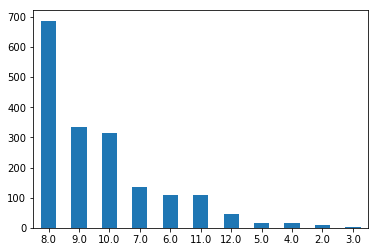

In [20]:
train_set1['domain1_score'].value_counts().plot(kind="bar", rot=0)

In [7]:
train_set1 = train_set1[train_set1.domain1_score != 3.0]

In [8]:
def evaluate_features(X, y, clf=None):
    """
    General helper function for evaluating effectiveness of passed features in ML model
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        y (array-like): Labels array. Shape (n_samples,)  
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

## Doc2Vec

In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [16]:
train_tagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_set1['essay'])]
#test_tagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(test_set1['essay'])]

In [18]:
max_epochs = 5
vec_size = 20
alpha = 0.025
model_train = Doc2Vec(vector_size=vec_size, window=5, min_count=10, workers=4)
#model_test = Doc2Vec(vector_size=vec_size, window=5, min_count=10, workers=4)

model_train.build_vocab(train_tagged)
#model_test.build_vocab(test_tagged)
for epoch in range(max_epochs):
    model_train.train(train_tagged, total_examples=model_train.corpus_count, epochs=epoch)
    model_train.alpha -= 0.0002
    model_train.min_alpha = model_train.alpha
    #model_test.train(test_tagged, total_examples=model_test.corpus_count, epochs=epoch)
    #model_test.alpha -= 0.0002
    #model_test.min_alpha = model_test.alpha

In [26]:
docvecs = model_train.docvecs.doctag_syn0 # np ndarray

/Users/LAR/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  if __name__ == '__main__':


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5740657658150123
Accuracy: 0.4264870931537598


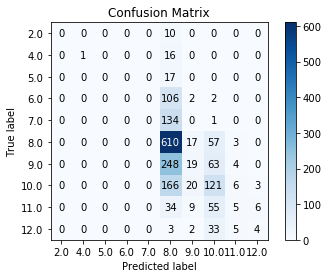

In [28]:
evaluate_features(docvecs, train_set1['domain1_score'].values.ravel())

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5586023055200047
Accuracy: 0.42312008978675647


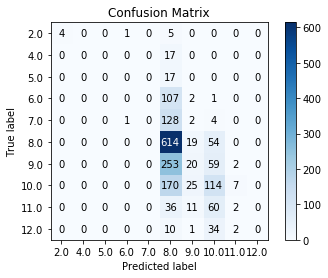

In [32]:
evaluate_features(docvecs, train_set1['domain1_score'].values.ravel(), 
                  RandomForestClassifier(n_estimators=300, max_depth=20, verbose=1))

## Bag of words

In [42]:
count_vectorizer = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
                                    preprocessor=None, stop_words='english', max_features=None)
bag_of_words = count_vectorizer.fit_transform(train_set1['essay'])

In [56]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.3962922528574724
Accuracy: 0.4478114478114478


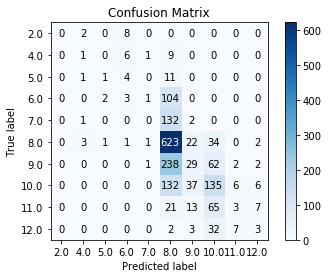

In [57]:
evaluate_features(truncated_bag_of_words, train_set1['domain1_score'].values.ravel())

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.3417509549009403
Accuracy: 0.4663299663299663


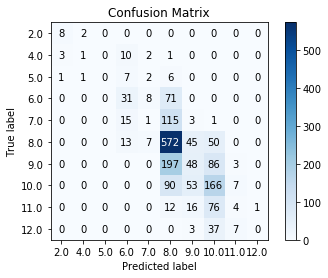

In [58]:
evaluate_features(truncated_bag_of_words, train_set1['domain1_score'].values.ravel(), 
                  RandomForestClassifier(n_estimators=300, max_depth=20, verbose=1))

## TFIDF

In [59]:
count_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
                    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(train_set1['essay'])

/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5748602381074912
Accuracy: 0.4163860830527497


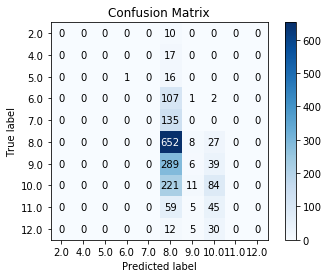

In [61]:
evaluate_features(tfidf, train_set1['domain1_score'].values.ravel())

In [62]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5777227684746364
Accuracy: 0.4158249158249158


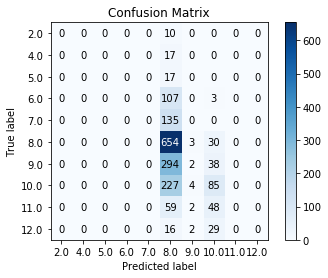

In [63]:
evaluate_features(truncated_tfidf, train_set1['domain1_score'].values.ravel())

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5897869103591256
Accuracy: 0.41245791245791247


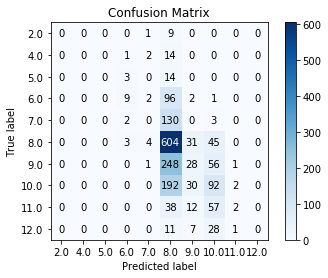

In [66]:
evaluate_features(truncated_tfidf, train_set1['domain1_score'].values.ravel(), 
                  RandomForestClassifier(n_estimators=200, max_depth=20, verbose=1))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.5s finished
/Users/LAR/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.463309532297183
Accuracy: 0.4287317620650954


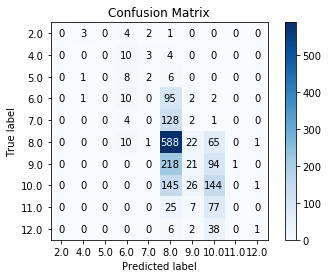

In [67]:
evaluate_features(tfidf, train_set1['domain1_score'].values.ravel(), SVC(kernel='linear', probability=True))